Name: Tan Ngiap Chuan Alvin

# Deep Learning - Practicum 4 - Generative Adversarial Networks

**Topics covered**: Generative Adversarial Networks(GAN) with Multi-layer Perceptron

**Deliverables**:
- Complete the tasks as detailed in this document.  <br>
This practice uses [Keras](https://keras.io/api/) with Tensorflow.

**Objectives**:
Usually a GAN is referring to DCGAN (deep convolution GAN): a GAN where the generator and discriminator are deep convnets. Training a DCGAN is computational cost. In this practice, deep convnets will be replaced with multi-layer perceptron. <br>
In this practice, we're to implement a standard GAN using a multi-layer perceptron for both the discriminator and generator. We train the GAN on MNIST images. After completing the tasks, you'll be get familiaried with the schematic GAN implementation. <br>

---
Import needed packages

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf

print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.4.1
Found GPU at: /device:GPU:0


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Mar 30 11:45:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |    222MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.705230847999701
GPU (s):
0.03887436400009392
GPU speedup over CPU: 69x


In [5]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras import layers, optimizers
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Introduction
Schematically, the GAN we're to implement looks like this: <br>
- 1 A generator network maps vectors of shape (latent_dim,) to images of shape (28, 28) which is the size of images from MNIST. <br>
- 2 A discriminator network maps images of shape (28, 28) to a binary score estimating the probability that the image is real. <br>
- 3 A gan network chains the generator and the discriminator together: gan(x) = discriminator(generator(x)). Thus this gan network maps latent space vectors to the discriminator’s assessment of the realism of these latent vectors as decoded by the generator. <br>
- 4 We train the discriminator using examples of real and fake images along with “real”/“fake” labels, just as you train any regular image-classification model. <br>
- 5 To train the generator, you use the gradients of the generator’s weights with regard to the loss of the gan model. This means, at every step, you move the weights of the generator in a direction that makes the discriminator more likely to classify as “real” the images decoded by the generator. In other words, you train the generator to fool the discriminator.

The settings of our GAN mode is given in the cell below.

In [6]:
latent_dim = 100
img_size = 28 * 28   # MNIST images

num_epochs = 100
batch_size = 128

## 2. Prepare Data

In [7]:
# load mnist data, only need train_data, the task is not for recognition, it doesn't need target
(x_train, _), (_, _) = mnist.load_data()
# print(x_train, x_train.shape, x_train.max(), x_train.min())

# Data Normalization
# Your code goes here
x_normal = (x_train - x_train.min()) / (x_train.max() - x_train.min())
print(x_normal.shape, x_normal.min(), x_normal.max())

# We're using multi-layered model, reshape image matrix into a vector (784,)
# Your code goes here
x_train = x_normal.reshape(60000, 784)

# The shape of the normalized and reshaped data set is (60000, 784)
print(x_train.shape)

# # random generator using a fixed seed to make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

(60000, 28, 28) 0.0 1.0
(60000, 784)


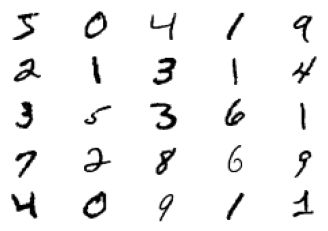

In [8]:
####----for own reference only----####
# plot 25 images from the training dataset
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(x_normal[i], cmap='gray_r')
plt.show()

## 3. Generator
First, let’s develop a generator model that turns a vector (from the latent space—during training it will be sampled at random) into a candidate image. <br>
- input shape: latent_dim <br>
- output shape: img_size <br>
Build up a 3-layer feed forward neural network. <br>
Suggested structure (you don't have to follow it) is as following: <br>
- hidden layer: 128 neuron, `LeakyReLU()`, `Dropout(0.5)`
- output layer: `tanh()`

In [9]:
# generator
# Your code goes here
# define the generator keras model
def get_generator():
    generator_model = Sequential()
    generator_model.add(layers.Dense(128, input_shape=(latent_dim, )))  # input n hidden layer
    generator_model.add(layers.LeakyReLU())
    generator_model.add(layers.Dropout(0.5))
    generator_model.add(layers.Dense(img_size, activation = 'tanh'))    # output layer
    # generator.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5))
    return generator_model

generator = get_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               101136    
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


## 4. Discriminator
Next, we’ll develop a discriminator model that takes as input a candidate image (real or synthetic) and classifies it into one of two classes: “generated image” or “real image that comes from the training set.” <br>
Build up a 3-layer feed forward neural network and compile it. <br>
Suggested structure (you don't have to follow it) is as follow: <br>
- hidden layer: 128 neuron, `LeakyReLU()`, `Dropout(0.5)` <br>
- output layer: `sigmod()` (It is compulsory that use sigmod for classification). <br>
- optimizer: `RMSprop(lr=0.0001, decay=1e-8)` <br>
- loss: `'binary_crossentropy'`

In [10]:
# discriminator
# Your code goes here

# define the discriminator keras model
def get_discriminator():
    discriminator_model = Sequential()
    discriminator_model.add(layers.Dense(128, input_shape=(img_size, ))) # input n hidden layer
    discriminator_model.add(layers.LeakyReLU())
    discriminator_model.add(layers.Dropout(0.5))
    discriminator_model.add(layers.Dense(1, activation = 'sigmoid'))    # output layer

    discriminator_model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=0.0001, decay=1e-8))
    return discriminator_model

discriminator = get_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


## 5. GAN
Finally, we’ll set up the GAN, which chains the generator and the discriminator. <br>
When trained, this model will move the generator in a direction that improves its ability to fool the discriminator. This model turns latent-space points into a classification decision—“fake” or “real”—and it’s meant to be trained with labels that are always “these are real images.” So, training gan will update the weights of generator in a way that makes discriminator more likely to predict “real” when looking at fake images. <br>
It’s very important to **note** that you set the discriminator to be frozen during training (non-trainable): its weights won’t be updated when training gan. <br>
Run the code in cell below to set up the GAN.

In [11]:
# GAN

discriminator.trainable = False                    # set the discriminator to be frozen
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr=0.0001, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## 6. Train the Model
Now we can begin training. For each epoch, do the following: <br>
- 1 Draw random points in the latent space (random noise). <br>
- 2 Generate images with generator using this random noise. <br>
- 3 Mix the generated images with real ones. <br>
- 4 Train discriminator using these mixed images, with corresponding targets: either “real” (for the real images) or “fake” (for the generated images). <br>
- 5 Draw new random points in the latent space. <br>
- 6 Train gan using these random vectors, with targets that all say “these are real images.” This updates the weights of the generator (only, because the discriminator is frozen inside gan) to move them toward getting the discriminator to predict “these are real images” for generated images: this trains the generator to fool the discriminator. <br>

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 0


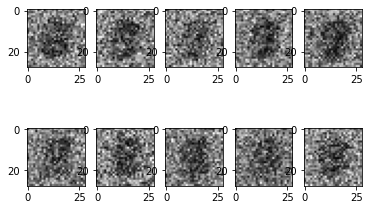

 20%|█▉        | 20/101 [06:19<25:29, 18.88s/it]

Epoch: 20


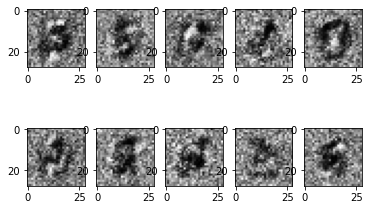

 40%|███▉      | 40/101 [12:38<19:10, 18.86s/it]

Epoch: 40


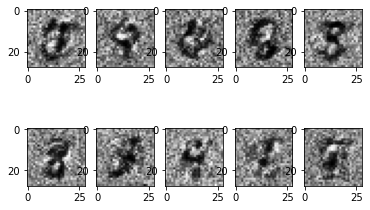

 59%|█████▉    | 60/101 [19:00<13:07, 19.20s/it]

Epoch: 60


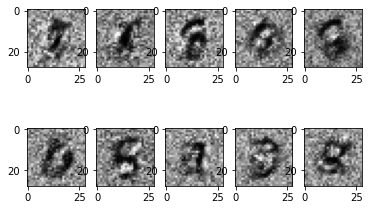

 79%|███████▉  | 80/101 [25:29<06:41, 19.13s/it]

Epoch: 80


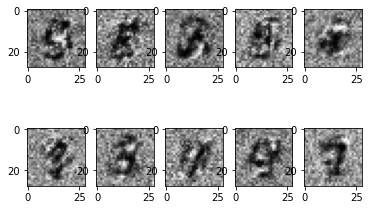

 99%|█████████▉| 100/101 [31:49<00:18, 18.78s/it]

Epoch: 100


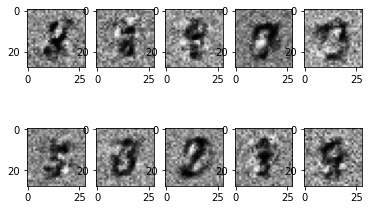

100%|██████████| 101/101 [32:09<00:00, 19.10s/it]


In [12]:
losses = {"D":[], "G":[]}

batchCount = int(x_train.shape[0] / batch_size) # 60000 / 128 = 468

# After successfully completeing the code in this cell, and hitting the run button
# go and grab a cup of tea or coffee, it'll take a while if you're using CPU

for epoch in tqdm(range(num_epochs+1)):  # num_epochs = 100
    for _ in range(batchCount):  #batchCount = 468 
        
        ###################################################################
        ####  Preparing real images and fake/generated images         #####
        ###################################################################
    
        # Create a batch by drawing random index numbers from the training set x_train         
        real_images = x_train[np.random.randint(0, x_train.shape[0], size = batch_size)] # Put your code here
    
        # Create noise vectors for the generator
        # TRICK, use normal distribution not a uniform distribution
        random_latent_vectors =  np.random.normal(0, 1, size=[batch_size, latent_dim]) # Put your code here
        
        # Use generator.predict() to generate the images from the noise
        generated_images = generator.predict(random_latent_vectors)# put your code here
        
        # Combine the two types of images
        combined_images = np.concatenate([generated_images, real_images])
#         print(f'combined_images shape: ', combined_images.shape)
        
        # Labels: genteratred - 0; real - 1
        labels = np.concatenate((np.zeros(batch_size), np.ones(batch_size)))

        # IMPORTANT TRICK: Adds random noise to the labels
        labels += 0.05 * np.random.random(labels.shape)
#         print(f'labels shape: ', labels.shape)
        
        ###################################################################
        ####  Train discriminator and generator                       #####
        ###################################################################
    
        # Train the discriminator on the combined_images and labels
        d_loss = discriminator.train_on_batch(combined_images, labels) # put your code here
        
        
        # Train the generator        
        # randomly generate the input, use normal distribution
        random_latent_vectors = np.random.normal(0, 1, size=[batch_size, latent_dim])# put your code here
        
        # Create labels that say “these are all real images”  - it’s a lie! In order to fool the discriminator
        misleading_targets = np.ones(batch_size) # put your code here
        
        # Train the generator via the GAN model, where the weights of generator are frozen
        g_loss = gan.train_on_batch(random_latent_vectors, misleading_targets) # put your code here
        
        # store losses for each batch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)
        
    # plot 10 images from generated samples every 20 epoch
    # Your code goes here
    
    def plot_generated_images(epoch, generator, num_e=100):
        # Let us visualize 10 examples: 
        # set the subplot
        fig, axs = plt.subplots(2, 5)
        for i in range(2):
            for j in range(5):  
                # plot image pixesles
                noise = np.random.normal(0, 1, size=[num_e, latent_dim])
                generated_images = generator.predict(noise)
#                 print(f'pre_reshape gen_images shape: {generated_images.shape}') #(100, 784)
                generated_images = generated_images.reshape(num_e, 28, 28)
                axs[i,j].imshow(np.reshape(generated_images[i+j], (28,28)), cmap='gray_r')
        # Display the image
        plt.show()

    # call the plot print function every 20 epoch
    if epoch % 20 == 0:
        print('Epoch:', epoch)
        plot_generated_images(epoch, generator)
        

## 7. Plot the learning curve
Plot the loss of discriminator and generator respectively. Generator loss should be decreasing along with the iteration number, while discriminator loss is increasing.

3000 3000


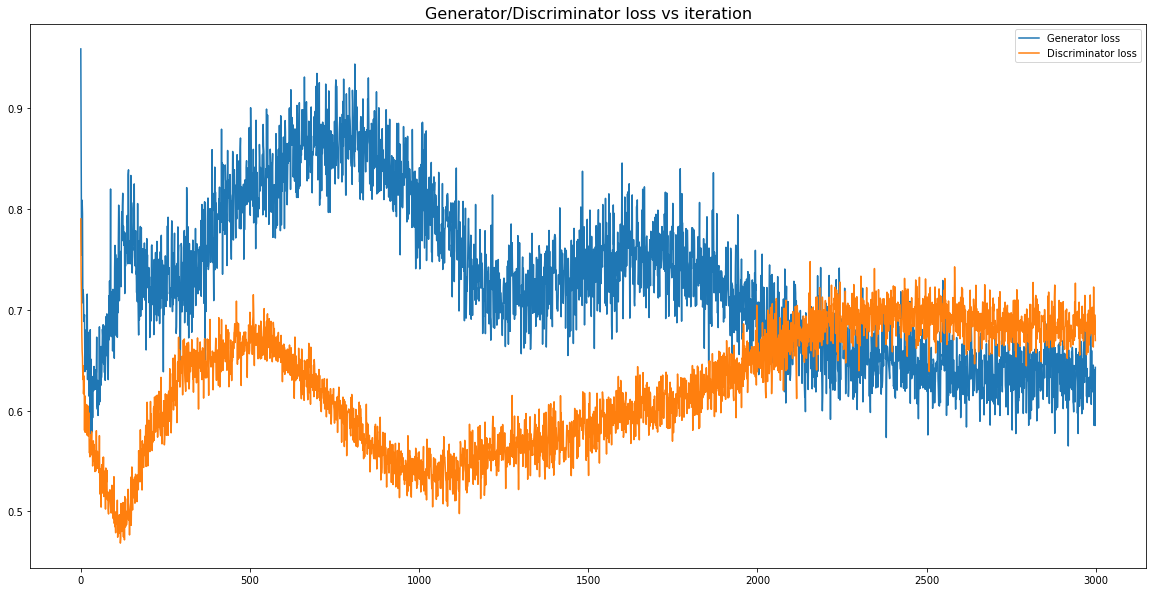

In [16]:
# Plot loss (First 3000 iteration counts)
# Your code goes here
def plotLoss(G, D):
    print(len(G), len(D))
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(G, label='Generator loss')
    ax.plot(D, label='Discriminator loss')
    ax.legend()
    ax.set_title('Generator/Discriminator loss vs iteration', fontsize=16)
    plt.show()

plotLoss(losses['G'][:3000], losses['D'][:3000])

47268 47268


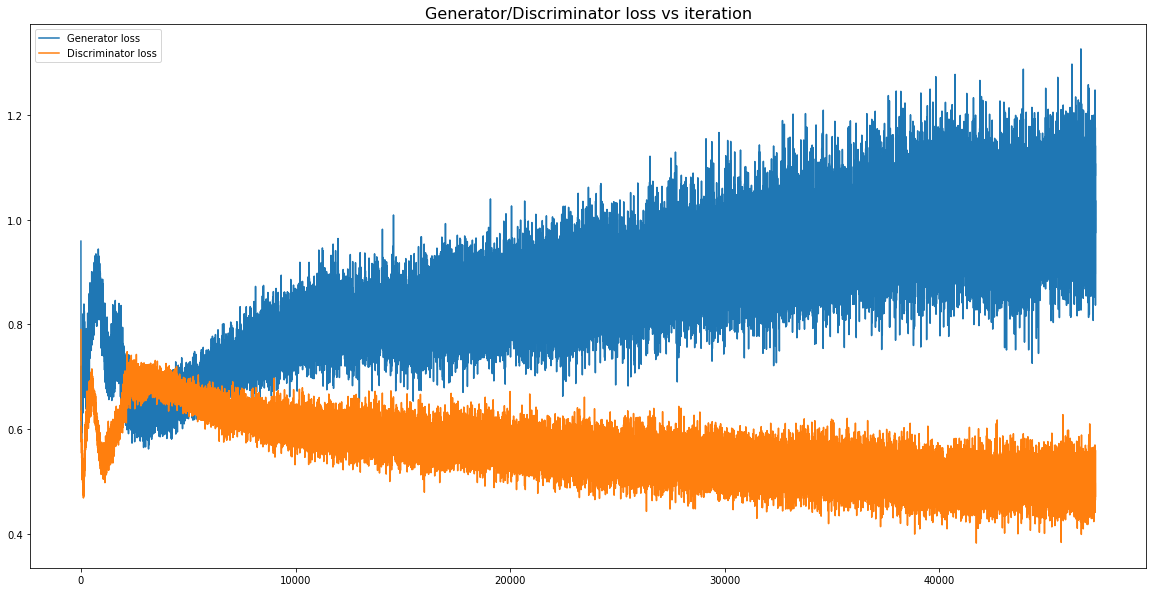

In [17]:
# Plot loss (all 47268 iteration counts)
# Your code goes here
def plotLoss(G, D):
    print(len(G), len(D))
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(G, label='Generator loss')
    ax.plot(D, label='Discriminator loss')
    ax.legend()
    ax.set_title('Generator/Discriminator loss vs iteration', fontsize=16)
    plt.show()

plotLoss(losses['G'], losses['D'])

# Observation
In the plot of first 3000 counts, we can see that Generator decreases (from initial loss of 0.95 to about 0.62) along with the iteration number, while discriminator loss is increasing (from inital loss of 0.45 to 0.69) at around 3000 iterative counts. 

But, beyond the first 5000 counts, we can see the trends reverse for both the Generator and Discriminator losses. The Generator loss starts to increase gradually to end with an average loss of 1.0 at the end of the full 47268 counts. The Discriminator loss starts to decrease to end with an average loss of 0.50 at the end of the full 47268 counts. 

From the first plot, we can also observe that the Generator and the Discriminator loss curves intersected at a loss value of about 0.65 at 2100 counts, which are possibly the optimal values for the loss and counts when the Generator and Discriminator 'match' each other equally.  